# Self-Organizing Map을 이용한 LoRa 심볼 분석

이 노트북에서는 SOM(Self-Organizing Map)을 사용하여 LoRa(Long Range) 심볼의 특성을 분석합니다.

**설정:**
- SF (Spreading Factor): 9
- 노이즈 없음 (Clean Signal)
- 심볼 개수: 2^9 = 512개

## 1. 라이브러리 임포트 및 설정

In [22]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# 상위 폴더의 utils 추가
sys.path.append('..')
sys.path.append('.')

# SOM 모듈 임포트
from som import SelfOrganizingMap, ComplexSOM
from utils.LoRa import LoRa

# 플롯 설정
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("모듈 임포트 완료!")

모듈 임포트 완료!


## 2. LoRa 심볼 생성

In [2]:
# LoRa 파라미터 설정
SF = 9  # Spreading Factor
BW = 125e3  # Bandwidth: 125 kHz
OSF = 1  # Oversampling Factor (1로 설정하여 심볼 길이 = 2^SF)

# LoRa 인스턴스 생성
lora = LoRa(sf=SF, bw=BW, OSF=OSF)

# 심볼 개수
num_symbols = 2 ** SF
print(f"SF = {SF}")
print(f"BW = {BW/1e3:.1f} kHz")
print(f"심볼 개수 = {num_symbols}")
print(f"심볼 당 샘플 수 = {num_symbols}")

SF = 9
BW = 125.0 kHz
심볼 개수 = 512
심볼 당 샘플 수 = 512


In [3]:
# 모든 심볼 생성 (노이즈 없음)
symbols = []
labels = []

for code_word in range(num_symbols):
    symbol = lora.gen_symbol(code_word, down=False)
    symbols.append(symbol)
    labels.append(code_word)

symbols = np.array(symbols)
labels = np.array(labels)

print(f"생성된 심볼 shape: {symbols.shape}")
print(f"심볼 데이터 타입: {symbols.dtype}")

생성된 심볼 shape: (512, 512)
심볼 데이터 타입: complex128


## 3. 심볼 시각화 (예시)

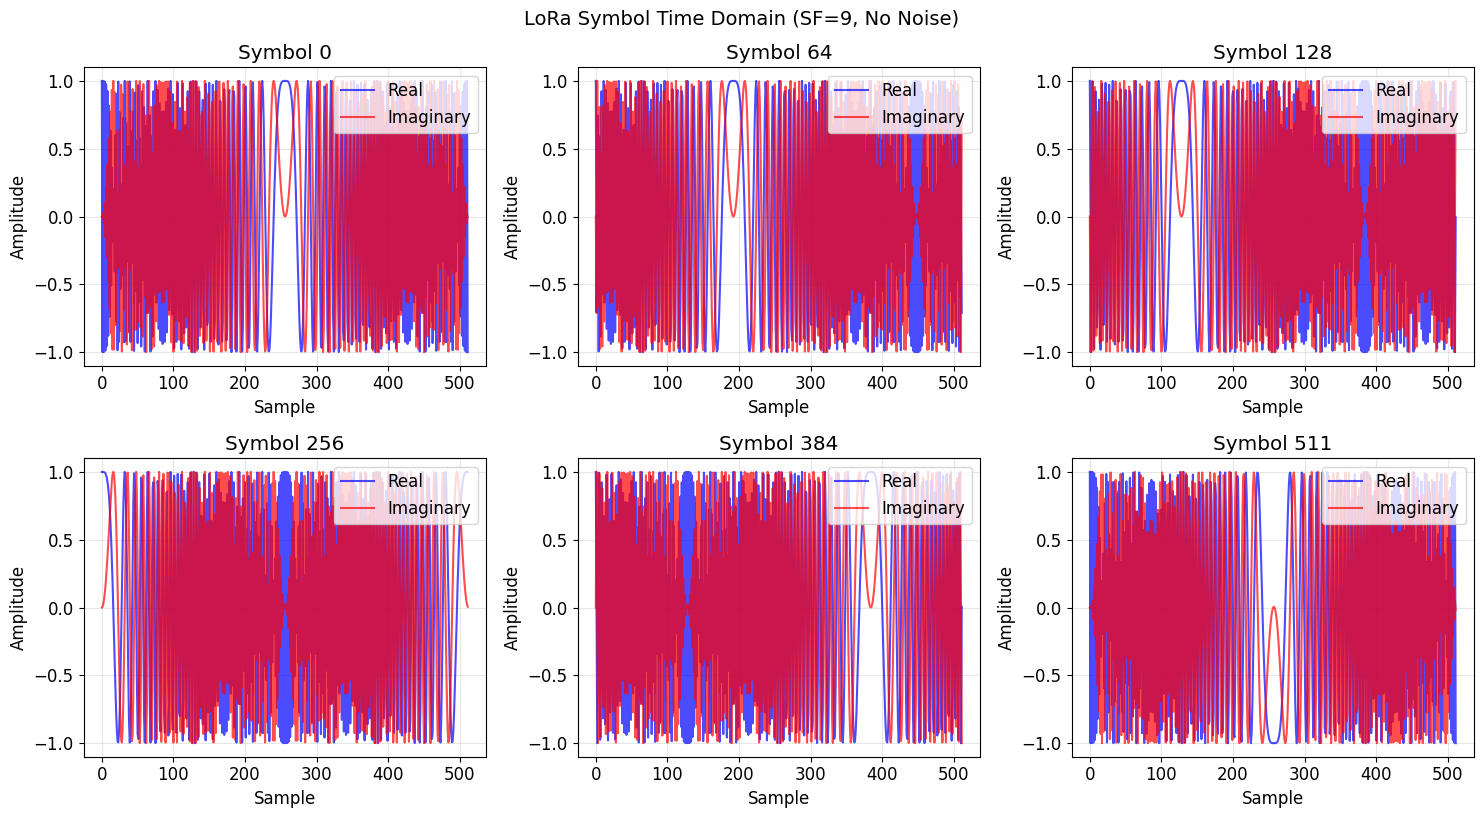

In [4]:
# 몇 가지 심볼 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

sample_symbols = [0, 64, 128, 256, 384, 511]

for idx, (ax, sym_idx) in enumerate(zip(axes.flat, sample_symbols)):
    symbol = symbols[sym_idx]
    t = np.arange(len(symbol))
    
    ax.plot(t, symbol.real, 'b-', alpha=0.7, label='Real')
    ax.plot(t, symbol.imag, 'r-', alpha=0.7, label='Imaginary')
    ax.set_title(f'Symbol {sym_idx}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('LoRa Symbol Time Domain (SF=9, No Noise)', y=1.02, fontsize=14)
plt.show()

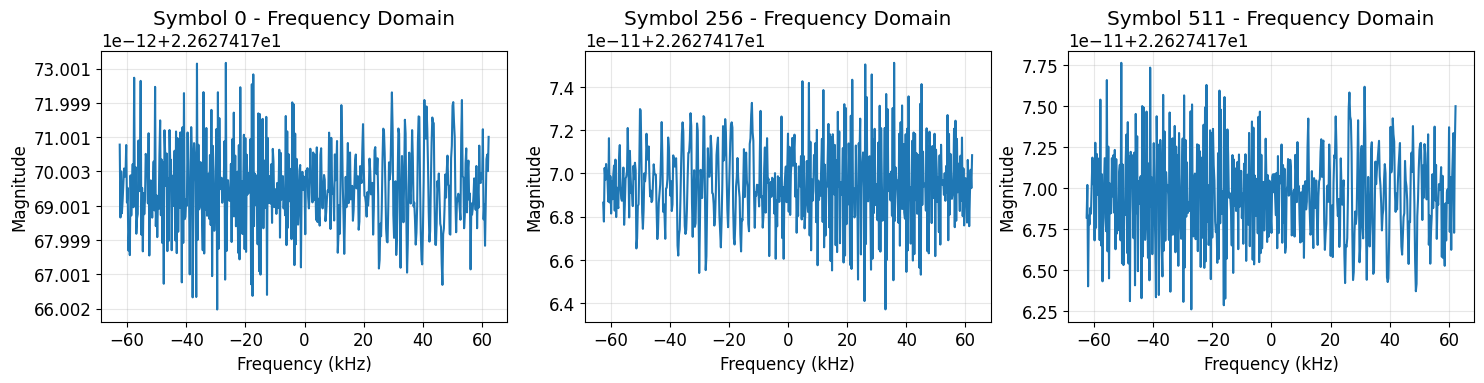

In [5]:
# 스펙트로그램 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, sym_idx in enumerate([0, 256, 511]):
    symbol = symbols[sym_idx]
    
    # FFT 계산
    fft_result = np.fft.fftshift(np.fft.fft(symbol))
    freq_axis = np.fft.fftshift(np.fft.fftfreq(len(symbol), 1/BW))
    
    axes[idx].plot(freq_axis/1e3, np.abs(fft_result))
    axes[idx].set_title(f'Symbol {sym_idx} - Frequency Domain')
    axes[idx].set_xlabel('Frequency (kHz)')
    axes[idx].set_ylabel('Magnitude')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. SOM을 위한 데이터 준비

복소수 심볼을 SOM에 입력하기 위해 다양한 표현 방식을 사용할 수 있습니다:
1. Real + Imaginary (concatenate)
2. Magnitude + Phase
3. FFT magnitude

여기서는 Real + Imaginary 방식을 사용합니다.

In [6]:
# 방법 1: Real + Imaginary concatenation
def prepare_data_real_imag(symbols):
    """복소수 심볼을 [real, imag] 형태로 변환"""
    real_part = symbols.real
    imag_part = symbols.imag
    data = np.hstack([real_part, imag_part])
    return data

# 방법 2: Magnitude + Phase
def prepare_data_mag_phase(symbols):
    """복소수 심볼을 [magnitude, phase] 형태로 변환"""
    magnitude = np.abs(symbols)
    phase = np.angle(symbols)
    data = np.hstack([magnitude, phase])
    return data

# 방법 3: FFT magnitude만 사용
def prepare_data_fft(symbols):
    """심볼의 FFT magnitude 사용"""
    fft_data = np.array([np.abs(np.fft.fft(s)) for s in symbols])
    return fft_data

# Real + Imaginary 방식 사용
data_real_imag = prepare_data_real_imag(symbols)
print(f"Data shape (Real+Imag): {data_real_imag.shape}")

# 정규화
data_normalized = (data_real_imag - data_real_imag.mean(axis=0)) / (data_real_imag.std(axis=0) + 1e-8)
print(f"Normalized data shape: {data_normalized.shape}")

Data shape (Real+Imag): (512, 1024)
Normalized data shape: (512, 1024)


## 5. SOM 학습

In [7]:
# SOM 파라미터 설정
MAP_SIZE = (24, 24)  # SOM 그리드 크기
INPUT_DIM = data_normalized.shape[1]  # 입력 차원
SIGMA = max(MAP_SIZE) / 2  # 초기 이웃 반경
LEARNING_RATE = 0.5  # 초기 학습률
NUM_ITERATIONS = 50000  # 학습 반복 횟수

print(f"SOM 설정:")
print(f"  - Map Size: {MAP_SIZE}")
print(f"  - Input Dimension: {INPUT_DIM}")
print(f"  - Initial Sigma: {SIGMA}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Iterations: {NUM_ITERATIONS}")

SOM 설정:
  - Map Size: (24, 24)
  - Input Dimension: 1024
  - Initial Sigma: 12.0
  - Learning Rate: 0.5
  - Iterations: 50000


In [8]:
# SOM 생성 및 학습
som = SelfOrganizingMap(
    map_size=MAP_SIZE,
    input_dim=INPUT_DIM,
    sigma=SIGMA,
    learning_rate=LEARNING_RATE,
    decay_function='exponential',
    random_seed=42
)

print("SOM 학습 시작...\n")
som.train(data_normalized, num_iterations=NUM_ITERATIONS, verbose=True)
print("\n학습 완료!")

SOM 학습 시작...

Iteration 5000/50000 - QE: 33.6789, TE: 0.0000, LR: 0.4801, σ: 9.2856
Iteration 10000/50000 - QE: 33.3904, TE: 0.0020, LR: 0.4611, σ: 7.1848
Iteration 15000/50000 - QE: 33.1138, TE: 0.0059, LR: 0.4427, σ: 5.5593
Iteration 20000/50000 - QE: 32.9579, TE: 0.0156, LR: 0.4251, σ: 4.3016
Iteration 25000/50000 - QE: 32.6691, TE: 0.3887, LR: 0.4083, σ: 3.3284
Iteration 30000/50000 - QE: 32.0876, TE: 0.0449, LR: 0.3920, σ: 2.5754
Iteration 35000/50000 - QE: 31.5443, TE: 0.0938, LR: 0.3765, σ: 1.9927
Iteration 40000/50000 - QE: 30.4500, TE: 0.5508, LR: 0.3615, σ: 1.5419
Iteration 45000/50000 - QE: 29.0219, TE: 0.5156, LR: 0.3471, σ: 1.1930
Iteration 50000/50000 - QE: 26.9579, TE: 0.4609, LR: 0.3333, σ: 0.9231

학습 완료!


## 6. 학습 결과 시각화

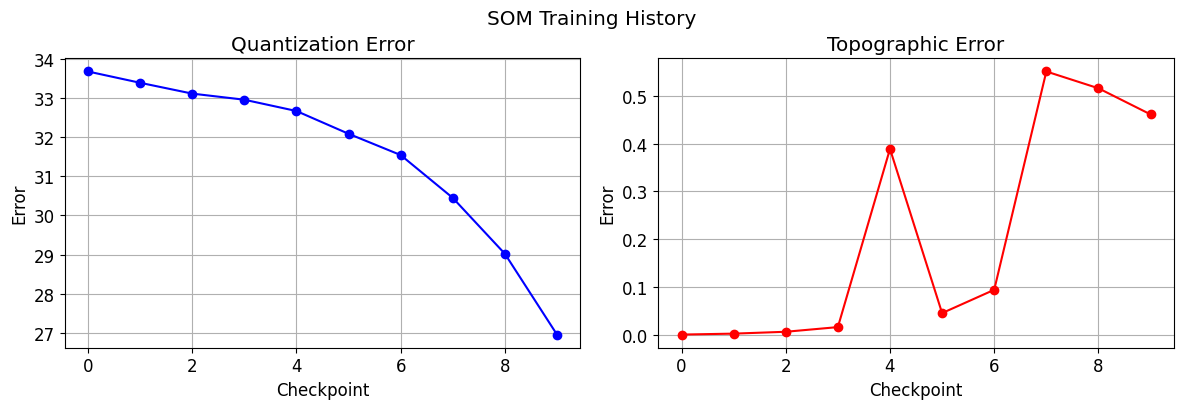

In [9]:
# 학습 히스토리
som.plot_training_history()
plt.suptitle('SOM Training History', y=1.02)
plt.show()

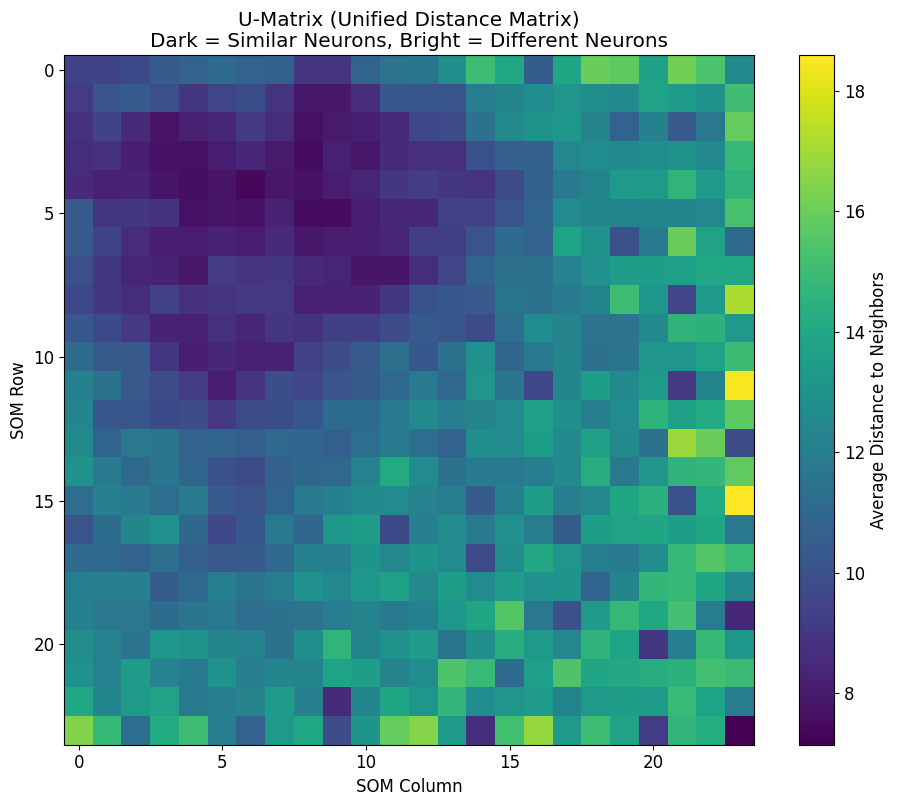

In [10]:
# U-Matrix 시각화
fig, ax = som.plot_u_matrix(figsize=(10, 8), cmap='viridis')
plt.title('U-Matrix (Unified Distance Matrix)\nDark = Similar Neurons, Bright = Different Neurons')
plt.show()

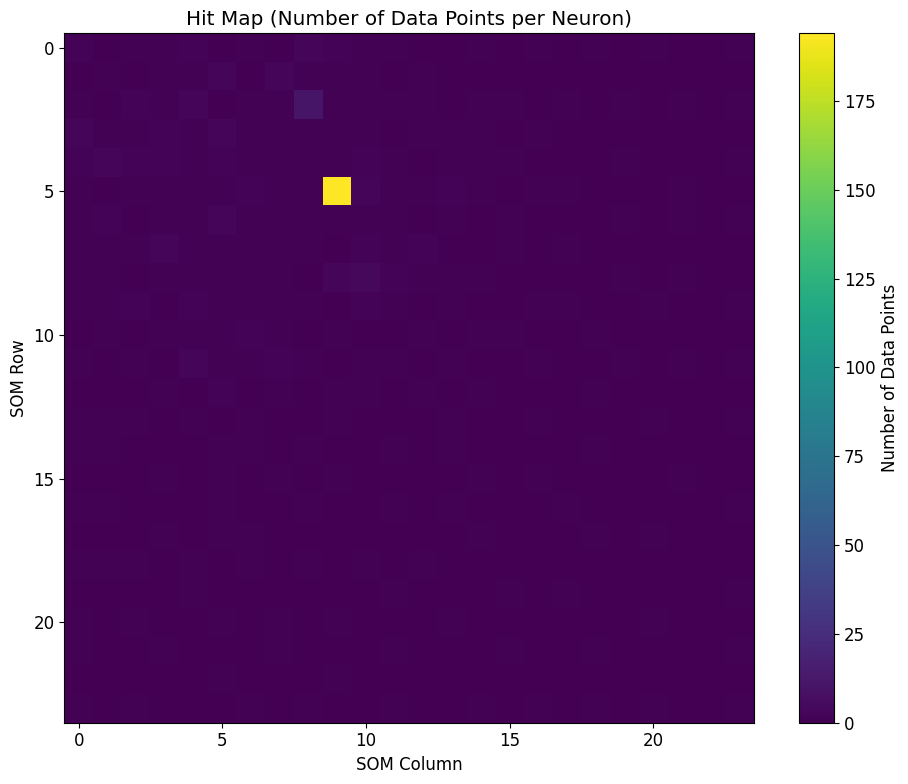

In [11]:
# Hit Map (각 뉴런에 매핑된 데이터 개수)
fig, ax = som.plot_winner_map(data_normalized, figsize=(10, 8))
plt.title('Hit Map (Number of Data Points per Neuron)')
plt.show()

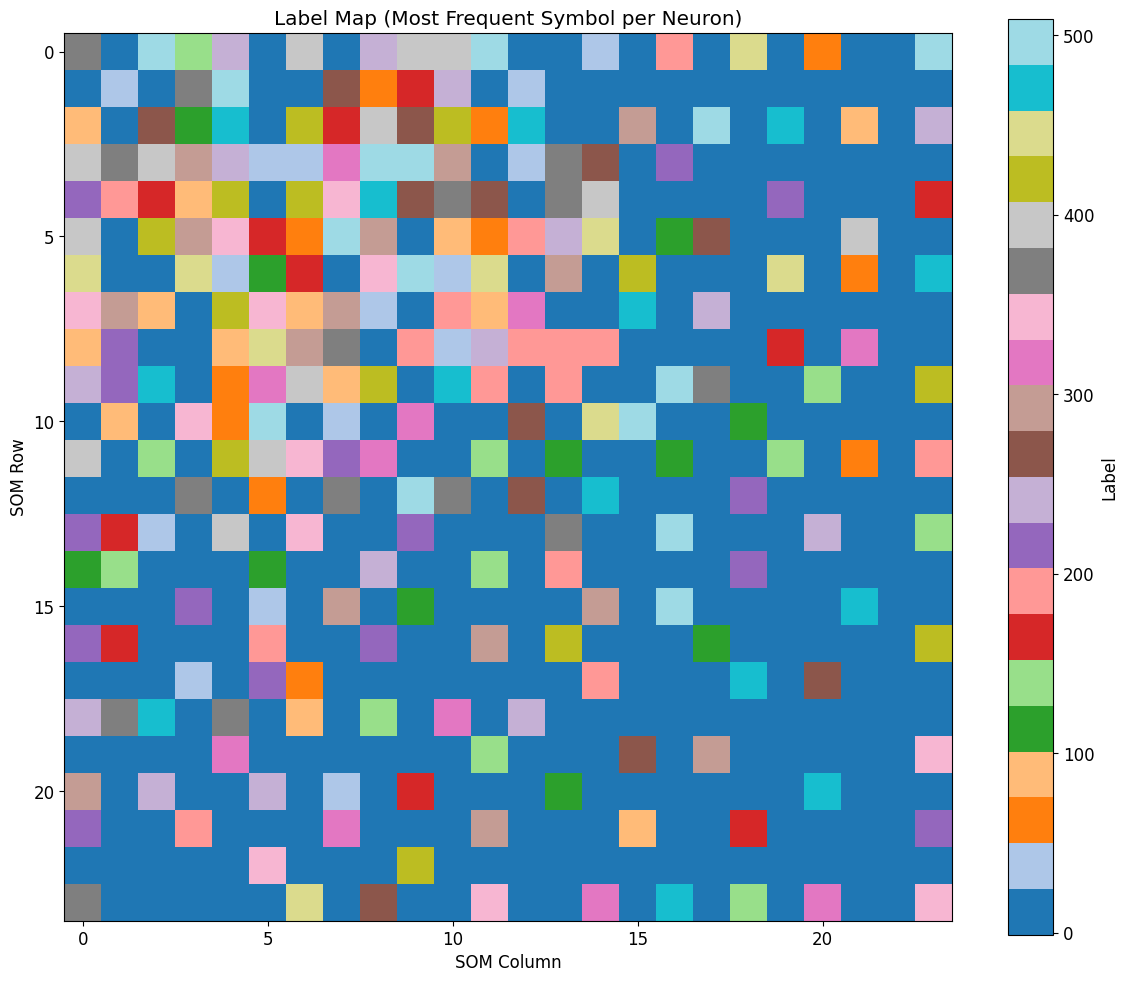

In [12]:
# Label Map (가장 빈번한 심볼 인덱스)
fig, ax = som.plot_winner_map(data_normalized, labels=labels, figsize=(12, 10))
plt.title('Label Map (Most Frequent Symbol per Neuron)')
plt.show()

## 7. 심볼 분포 분석

In [13]:
# 심볼들의 BMU 위치 계산
bmu_positions = []
for i, x in enumerate(data_normalized):
    bmu = som.predict(x)
    bmu_positions.append(bmu)

bmu_positions = np.array(bmu_positions)
print(f"BMU positions shape: {bmu_positions.shape}")

BMU positions shape: (512, 2)


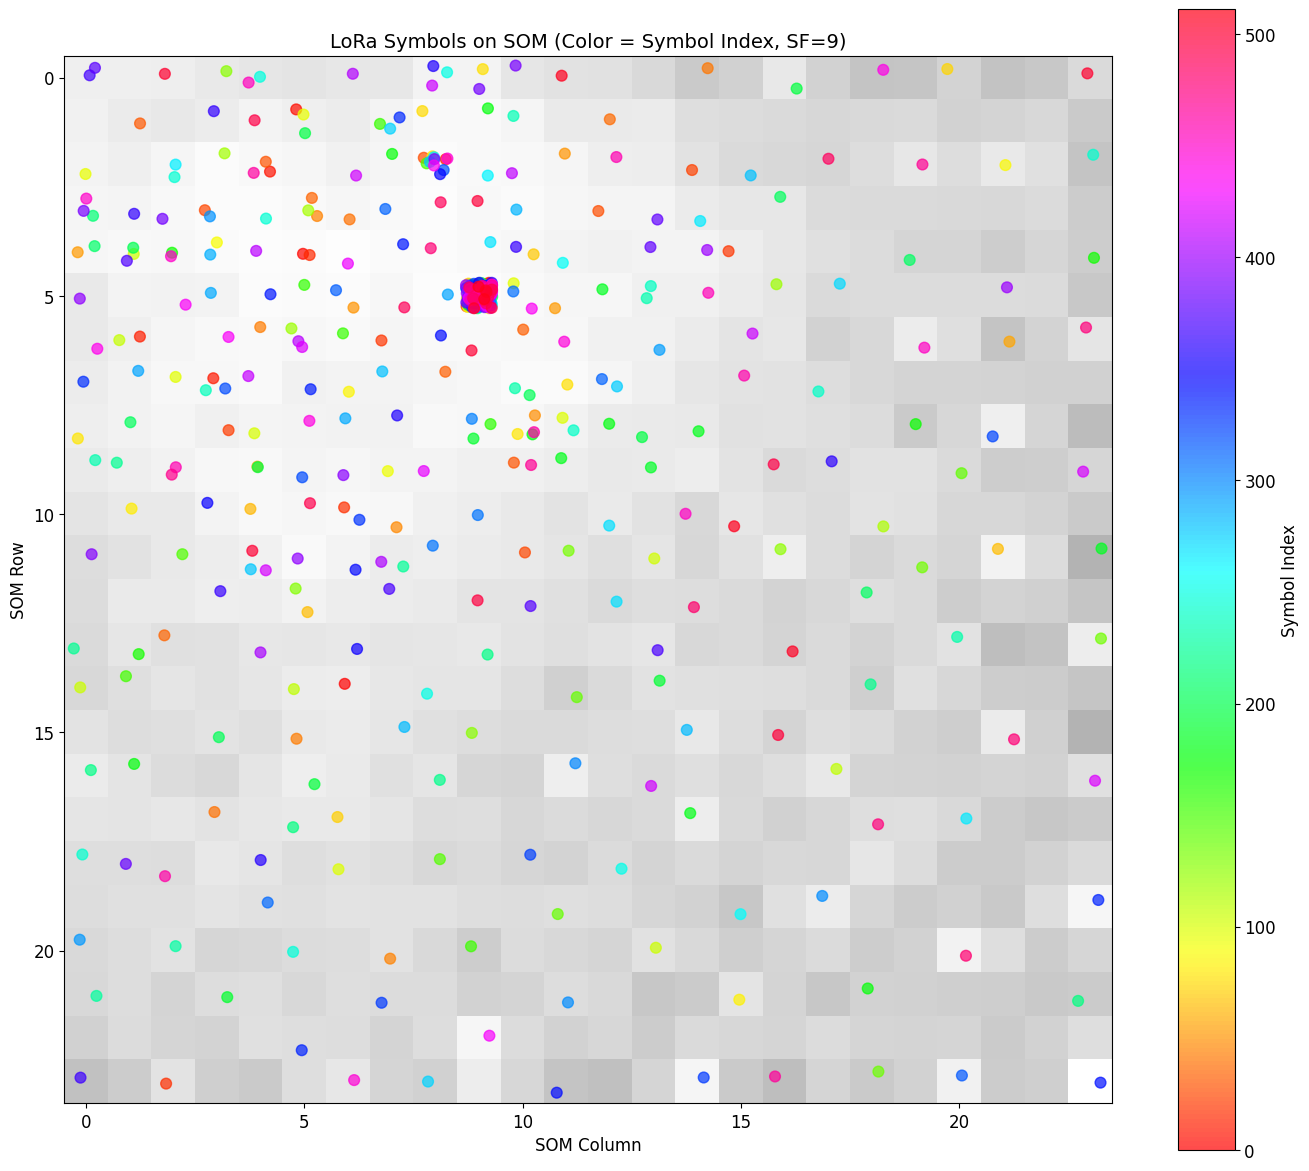

In [14]:
# 심볼 인덱스별 색상 매핑하여 시각화
fig, ax = plt.subplots(figsize=(14, 12))

# U-Matrix를 배경으로
u_matrix = som.get_u_matrix()
ax.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')

# 심볼 인덱스에 따라 색상 지정
scatter = ax.scatter(
    bmu_positions[:, 1] + np.random.uniform(-0.3, 0.3, len(bmu_positions)),  # column (x)
    bmu_positions[:, 0] + np.random.uniform(-0.3, 0.3, len(bmu_positions)),  # row (y)
    c=labels,
    cmap='hsv',
    alpha=0.7,
    s=60
)

plt.colorbar(scatter, ax=ax, label='Symbol Index')
ax.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
ax.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
ax.set_title('LoRa Symbols on SOM (Color = Symbol Index, SF=9)', fontsize=14)
ax.set_xlabel('SOM Column')
ax.set_ylabel('SOM Row')
plt.tight_layout()
plt.show()

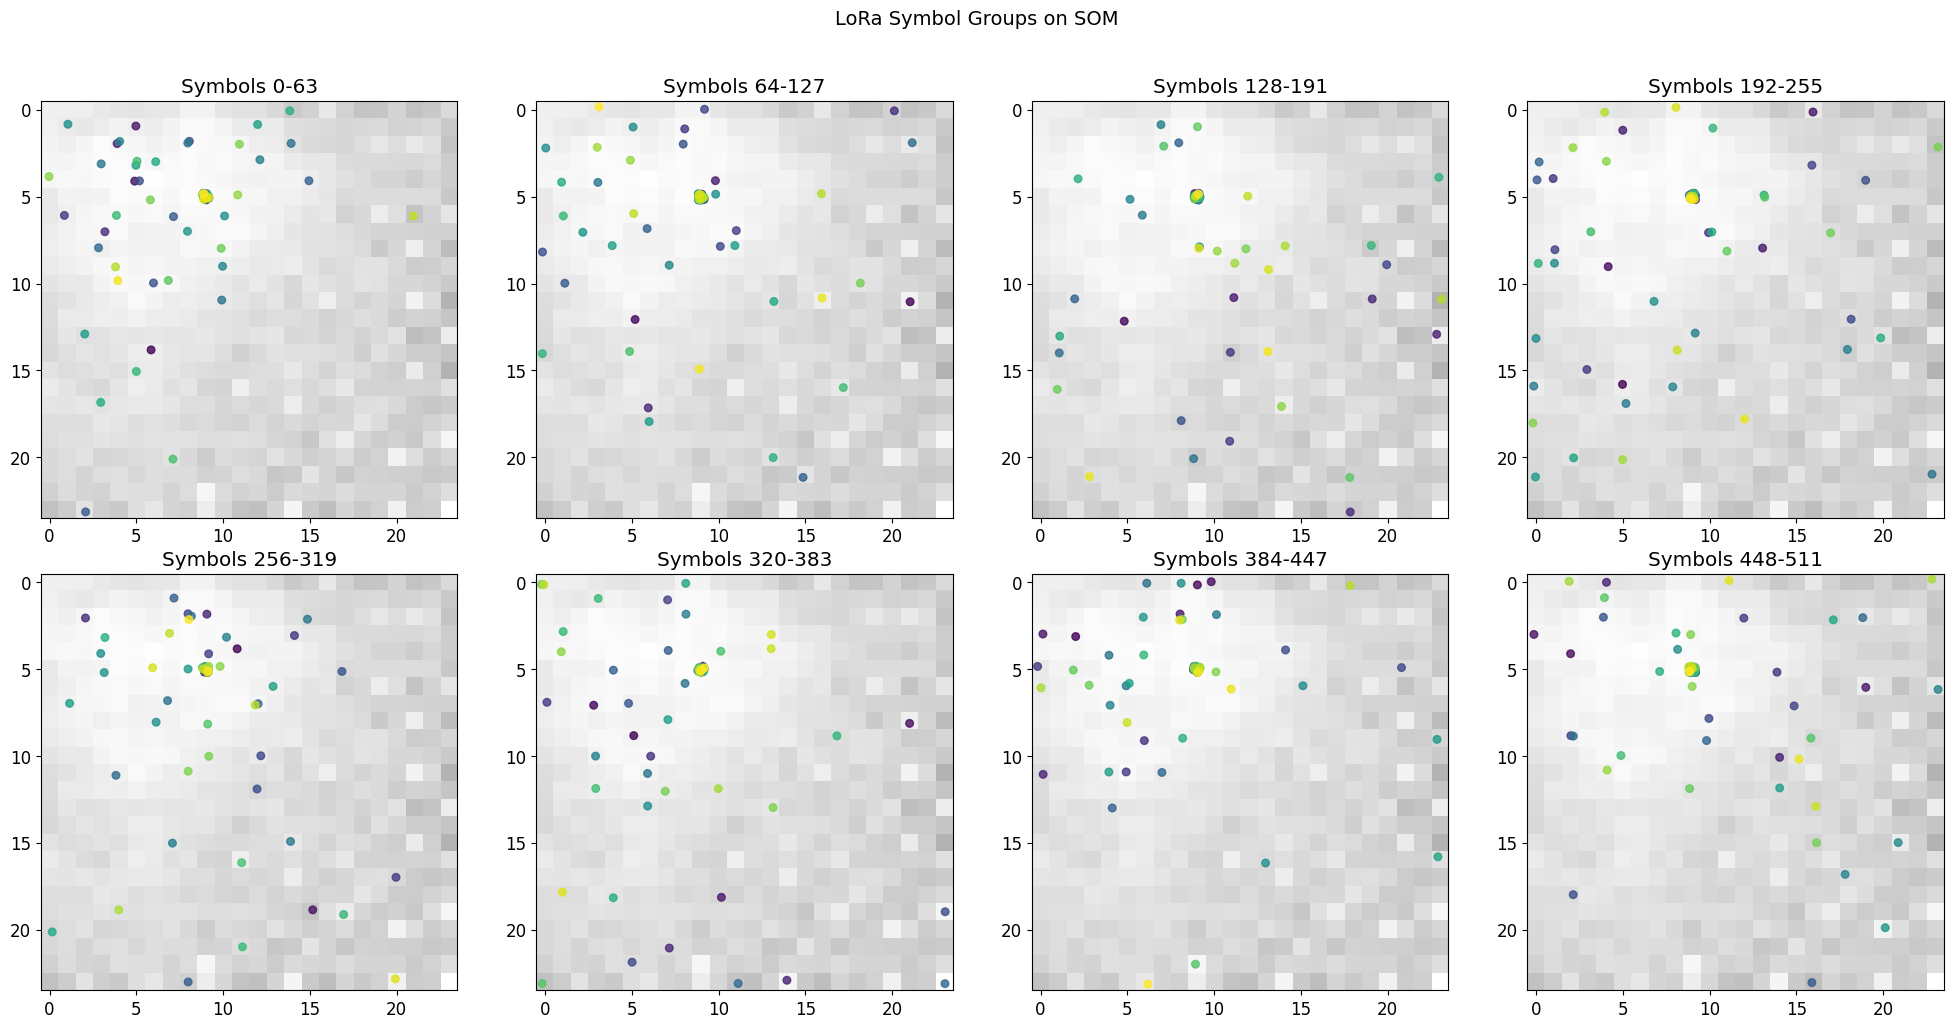

In [15]:
# 심볼 그룹별 시각화 (64개씩 8그룹)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

group_size = num_symbols // 8
colors = plt.cm.tab10(np.linspace(0, 1, 8))

for i, ax in enumerate(axes.flat):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size
    
    # 배경 U-Matrix
    ax.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
    
    # 해당 그룹의 심볼만 표시
    mask = (labels >= start_idx) & (labels < end_idx)
    group_positions = bmu_positions[mask]
    group_labels = labels[mask]
    
    scatter = ax.scatter(
        group_positions[:, 1] + np.random.uniform(-0.2, 0.2, len(group_positions)),
        group_positions[:, 0] + np.random.uniform(-0.2, 0.2, len(group_positions)),
        c=group_labels,
        cmap='viridis',
        alpha=0.8,
        s=30
    )
    
    ax.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
    ax.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
    ax.set_title(f'Symbols {start_idx}-{end_idx-1}')

plt.suptitle('LoRa Symbol Groups on SOM', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. 인접 심볼 분석

In [16]:
# 인접한 심볼들이 SOM에서 얼마나 가까운지 분석
def calculate_bmu_distance(idx1, idx2):
    """두 심볼의 BMU 사이 유클리드 거리"""
    return np.sqrt((bmu_positions[idx1, 0] - bmu_positions[idx2, 0])**2 + 
                   (bmu_positions[idx1, 1] - bmu_positions[idx2, 1])**2)

# 연속된 심볼 간 거리
consecutive_distances = []
for i in range(num_symbols - 1):
    dist = calculate_bmu_distance(i, i + 1)
    consecutive_distances.append(dist)

# Circular distance (마지막 심볼과 첫 심볼)
wrap_distance = calculate_bmu_distance(num_symbols - 1, 0)
consecutive_distances.append(wrap_distance)

consecutive_distances = np.array(consecutive_distances)

print(f"연속 심볼 간 BMU 거리 통계:")
print(f"  평균: {consecutive_distances.mean():.3f}")
print(f"  표준편차: {consecutive_distances.std():.3f}")
print(f"  최소: {consecutive_distances.min():.3f}")
print(f"  최대: {consecutive_distances.max():.3f}")

연속 심볼 간 BMU 거리 통계:
  평균: 8.079
  표준편차: 5.776
  최소: 0.000
  최대: 28.018


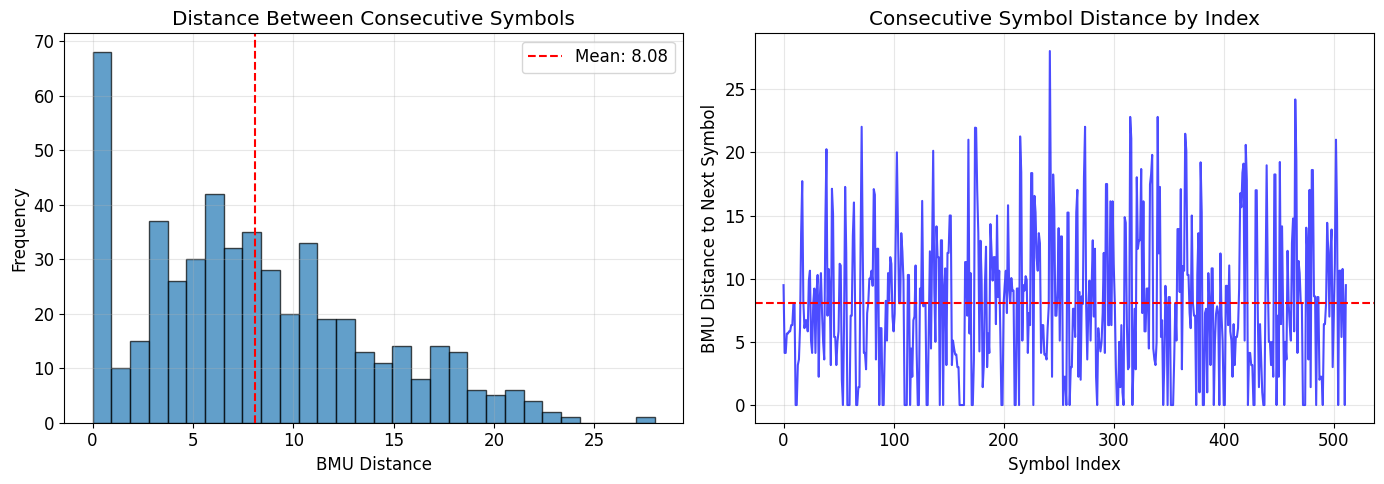

In [17]:
# 연속 심볼 간 거리 히스토그램
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(consecutive_distances, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(consecutive_distances.mean(), color='red', linestyle='--', 
                label=f'Mean: {consecutive_distances.mean():.2f}')
axes[0].set_xlabel('BMU Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distance Between Consecutive Symbols')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 심볼 인덱스별 거리
axes[1].plot(consecutive_distances, 'b-', alpha=0.7)
axes[1].axhline(consecutive_distances.mean(), color='red', linestyle='--')
axes[1].set_xlabel('Symbol Index')
axes[1].set_ylabel('BMU Distance to Next Symbol')
axes[1].set_title('Consecutive Symbol Distance by Index')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. FFT 기반 SOM (대안적 접근)

In [18]:
# FFT magnitude로 다시 학습
data_fft = prepare_data_fft(symbols)
data_fft_normalized = (data_fft - data_fft.mean(axis=0)) / (data_fft.std(axis=0) + 1e-8)

print(f"FFT Data shape: {data_fft_normalized.shape}")

FFT Data shape: (512, 512)


In [19]:
# FFT 기반 SOM
som_fft = SelfOrganizingMap(
    map_size=(24, 24),
    input_dim=data_fft_normalized.shape[1],
    sigma=12,
    learning_rate=0.5,
    decay_function='exponential',
    random_seed=42
)

print("FFT 기반 SOM 학습 시작...\n")
som_fft.train(data_fft_normalized, num_iterations=50000, verbose=True)
print("\n학습 완료!")

FFT 기반 SOM 학습 시작...

Iteration 5000/50000 - QE: 0.0045, TE: 0.0566, LR: 0.4801, σ: 9.2856
Iteration 10000/50000 - QE: 0.0044, TE: 0.0605, LR: 0.4611, σ: 7.1848
Iteration 15000/50000 - QE: 0.0042, TE: 0.0742, LR: 0.4427, σ: 5.5593
Iteration 20000/50000 - QE: 0.0040, TE: 0.0957, LR: 0.4251, σ: 4.3016
Iteration 25000/50000 - QE: 0.0038, TE: 0.1035, LR: 0.4083, σ: 3.3284
Iteration 30000/50000 - QE: 0.0036, TE: 0.1191, LR: 0.3920, σ: 2.5754
Iteration 35000/50000 - QE: 0.0034, TE: 0.1230, LR: 0.3765, σ: 1.9927
Iteration 40000/50000 - QE: 0.0032, TE: 0.1289, LR: 0.3615, σ: 1.5419
Iteration 45000/50000 - QE: 0.0029, TE: 0.1367, LR: 0.3471, σ: 1.1930
Iteration 50000/50000 - QE: 0.0026, TE: 0.0957, LR: 0.3333, σ: 0.9231

학습 완료!


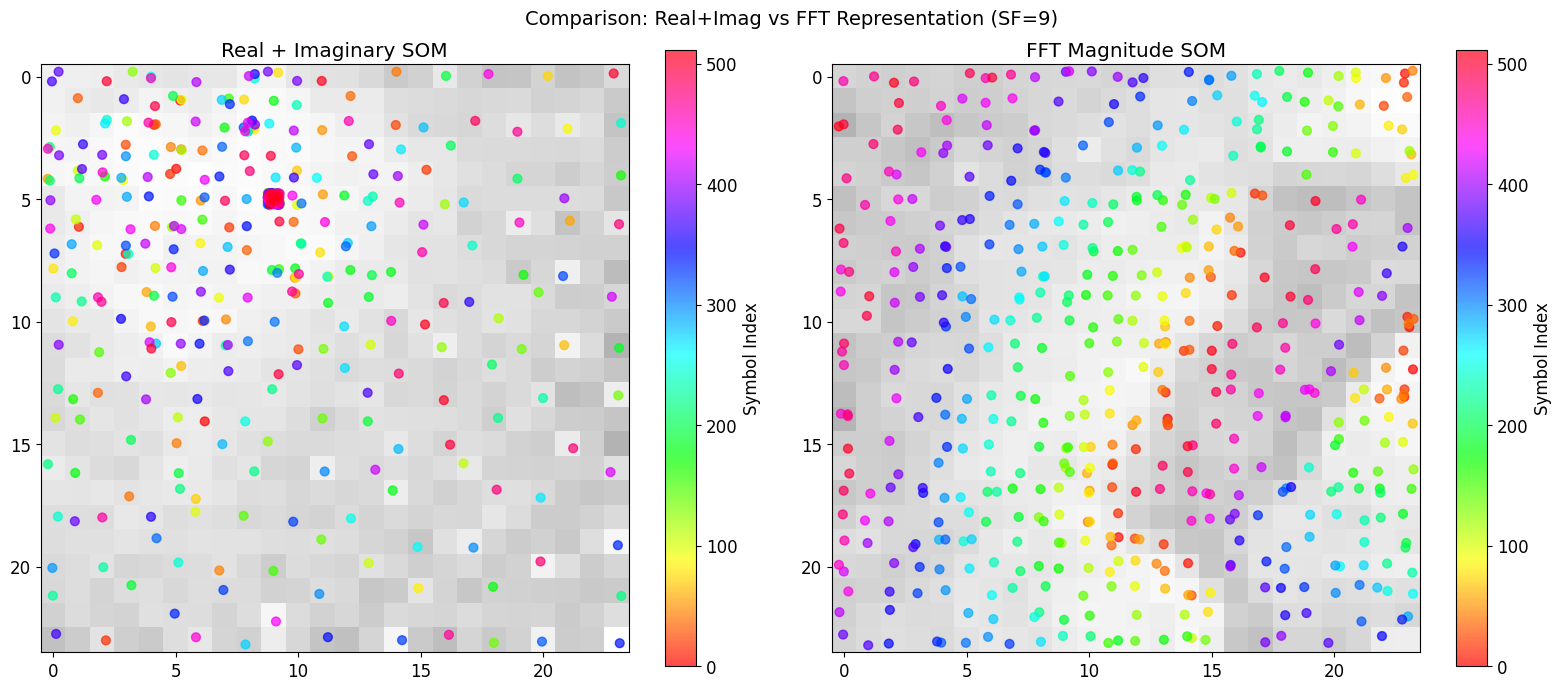

In [20]:
# FFT SOM 결과 시각화
bmu_positions_fft = np.array([som_fft.predict(x) for x in data_fft_normalized])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Real+Imag SOM
u_matrix = som.get_u_matrix()
axes[0].imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
scatter1 = axes[0].scatter(
    bmu_positions[:, 1] + np.random.uniform(-0.25, 0.25, len(bmu_positions)),
    bmu_positions[:, 0] + np.random.uniform(-0.25, 0.25, len(bmu_positions)),
    c=labels, cmap='hsv', alpha=0.7, s=40
)
axes[0].set_xlim(-0.5, MAP_SIZE[1] - 0.5)
axes[0].set_ylim(MAP_SIZE[0] - 0.5, -0.5)
axes[0].set_title('Real + Imaginary SOM')
plt.colorbar(scatter1, ax=axes[0], label='Symbol Index')

# FFT SOM
u_matrix_fft = som_fft.get_u_matrix()
axes[1].imshow(u_matrix_fft, cmap='gray_r', alpha=0.3, interpolation='nearest')
scatter2 = axes[1].scatter(
    bmu_positions_fft[:, 1] + np.random.uniform(-0.25, 0.25, len(bmu_positions_fft)),
    bmu_positions_fft[:, 0] + np.random.uniform(-0.25, 0.25, len(bmu_positions_fft)),
    c=labels, cmap='hsv', alpha=0.7, s=40
)
axes[1].set_xlim(-0.5, MAP_SIZE[1] - 0.5)
axes[1].set_ylim(MAP_SIZE[0] - 0.5, -0.5)
axes[1].set_title('FFT Magnitude SOM')
plt.colorbar(scatter2, ax=axes[1], label='Symbol Index')

plt.suptitle('Comparison: Real+Imag vs FFT Representation (SF=9)', fontsize=14)
plt.tight_layout()
plt.show()

## 10. 결론 및 관찰

In [21]:
# 최종 에러 비교
print("=" * 50)
print("최종 결과 요약")
print("=" * 50)
print(f"\n[Real + Imaginary SOM]")
print(f"  Quantization Error: {som.quantization_error(data_normalized):.4f}")
print(f"  Topographic Error: {som.topographic_error(data_normalized):.4f}")

print(f"\n[FFT Magnitude SOM]")
print(f"  Quantization Error: {som_fft.quantization_error(data_fft_normalized):.4f}")
print(f"  Topographic Error: {som_fft.topographic_error(data_fft_normalized):.4f}")

print("\n" + "=" * 50)
print("관찰 사항:")
print("- LoRa 심볼은 code word에 따라 위상이 순환적으로 변화")
print("- SOM 맵에서 유사한 심볼들이 군집화됨")
print("- 연속적인 심볼들이 대체로 인접한 위치에 매핑됨")
print("=" * 50)

최종 결과 요약

[Real + Imaginary SOM]
  Quantization Error: 26.9579
  Topographic Error: 0.4609

[FFT Magnitude SOM]
  Quantization Error: 0.0026
  Topographic Error: 0.0957

관찰 사항:
- LoRa 심볼은 code word에 따라 위상이 순환적으로 변화
- SOM 맵에서 유사한 심볼들이 군집화됨
- 연속적인 심볼들이 대체로 인접한 위치에 매핑됨


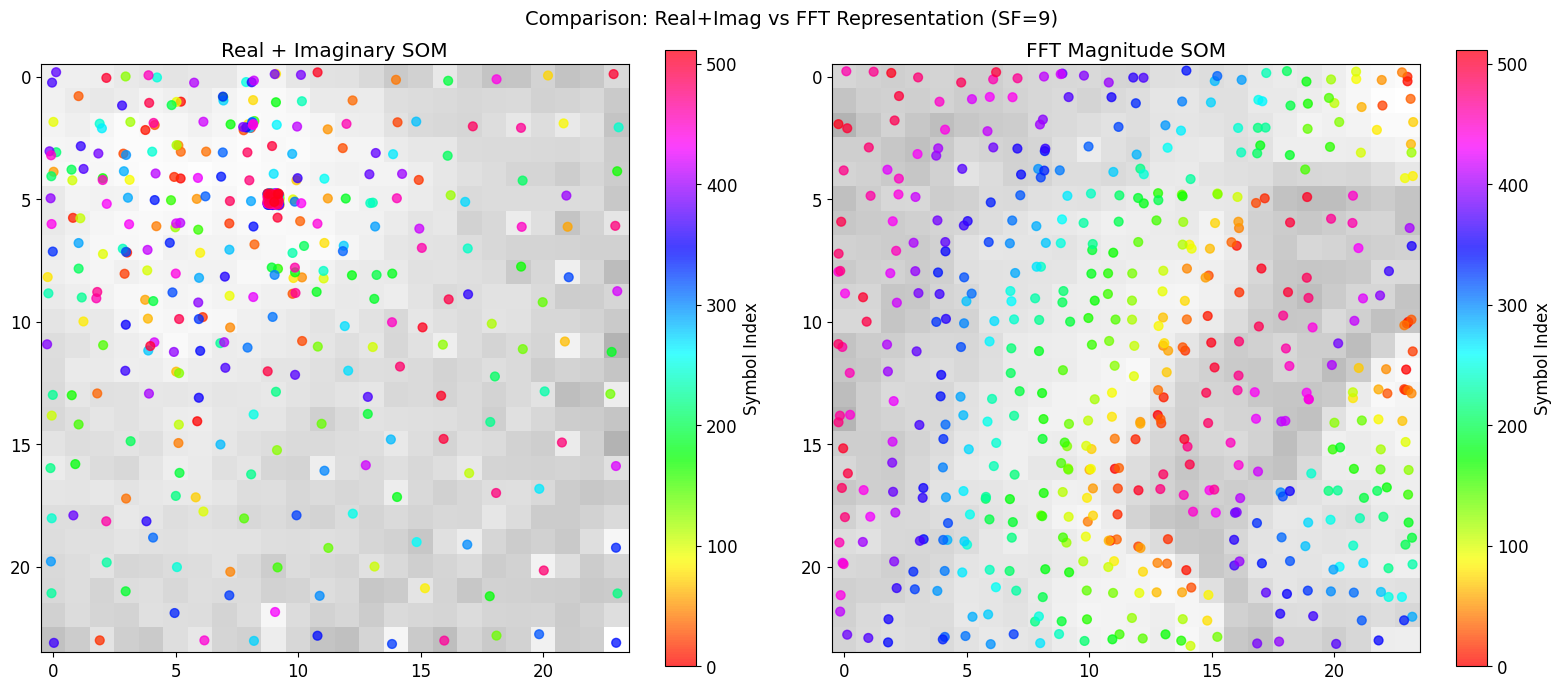

Saved: /home/gwon9906/self-organizing-map/docs/assets/comparison_realimag_vs_fft.png


In [23]:
# 결과 이미지 저장 (repo/docs/assets)
from pathlib import Path
import numpy as np

def _find_repo_root() -> Path:
    here = Path.cwd().resolve()
    for p in (here, *here.parents):
        if (p / "utils" / "LoRa.py").exists() and (p / "model-test" / "som.py").exists():
            return p
    return here

ROOT = _find_repo_root()
out_dir = ROOT / "docs" / "assets"
out_dir.mkdir(parents=True, exist_ok=True)

rng = np.random.default_rng(0)

# 1) Real+Imag vs FFT magnitude 비교 그림 저장
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Real+Imag SOM
axes[0].imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
jit = rng.uniform(-0.25, 0.25, size=bmu_positions.shape)
sc1 = axes[0].scatter(
    bmu_positions[:, 1] + jit[:, 1],
    bmu_positions[:, 0] + jit[:, 0],
    c=labels, cmap='hsv', alpha=0.75, s=40,
)
axes[0].set_xlim(-0.5, MAP_SIZE[1] - 0.5)
axes[0].set_ylim(MAP_SIZE[0] - 0.5, -0.5)
axes[0].set_title('Real + Imaginary SOM')
plt.colorbar(sc1, ax=axes[0], label='Symbol Index')

# FFT SOM
axes[1].imshow(u_matrix_fft, cmap='gray_r', alpha=0.3, interpolation='nearest')
jit2 = rng.uniform(-0.25, 0.25, size=bmu_positions_fft.shape)
sc2 = axes[1].scatter(
    bmu_positions_fft[:, 1] + jit2[:, 1],
    bmu_positions_fft[:, 0] + jit2[:, 0],
    c=labels, cmap='hsv', alpha=0.75, s=40,
)
axes[1].set_xlim(-0.5, MAP_SIZE[1] - 0.5)
axes[1].set_ylim(MAP_SIZE[0] - 0.5, -0.5)
axes[1].set_title('FFT Magnitude SOM')
plt.colorbar(sc2, ax=axes[1], label='Symbol Index')

plt.suptitle('Comparison: Real+Imag vs FFT Representation (SF=9)', fontsize=14)
plt.tight_layout()

out_path = out_dir / "comparison_realimag_vs_fft.png"
fig.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"Saved: {out_path}")